# Demo Convolucional RNA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Procesamiento de archivos
import os
from shutil import copyfile
import random

## Exploración

In [2]:
# Con esta celda, descargan el dataset desde el repositorio del curso
# Así evitan arrastrar al espacio de trabajo

!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR&confirm=t" -O partes_mecanicas.zip

--2023-11-24 22:31:39--  https://drive.google.com/uc?export=download&id=1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR&confirm=t
Resolving drive.google.com (drive.google.com)... 173.194.79.113, 173.194.79.138, 173.194.79.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.79.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oea47evu24oo5h2qgogt5d75jpnkp2ni/1700865075000/12225850433951268217/*/1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR?e=download&uuid=67140c11-6fe1-46c2-bc7b-b60db1443d28 [following]
--2023-11-24 22:31:40--  https://doc-0k-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oea47evu24oo5h2qgogt5d75jpnkp2ni/1700865075000/12225850433951268217/*/1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR?e=download&uuid=67140c11-6fe1-46c2-bc7b-b60db1443d28
Resolving doc-0k-9c-docs.googleusercontent.com (doc-0k-9c-docs.googleusercontent.com)... 142.250.145

In [3]:
!unzip -qq partes_mecanicas.zip

In [4]:
def explora_dir(directory_name):
    '''
    Acepta el nombre de directorio como argumento e imprime el contenido de cada directorio secuencialmente.
    Imprime los subdirectorios y el número de imágenes presentes en cada uno.
    '''
    for dirpaths, dirnames, filenames in os.walk(directory_name):
        print(f"Existen {len(dirnames)} directorios y {len(filenames)} imágenes en '{dirpaths}'")

In [5]:
dir_datos = './partes_mecanicas'
explora_dir(dir_datos)

Existen 4 directorios y 0 imágenes en './partes_mecanicas'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/tornillo'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/tuerca'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/pasador'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/arandela'


## Subvivisión del dataset

In [6]:
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/test')
for folder in os.listdir(dir_datos):
    files=os.listdir(os.path.join(dir_datos, folder))
    images=[]
    for f in files:
        try:
            img=tf.io.read_file(os.path.join(dir_datos, folder,f))
            img=tf.image.decode_image(img)
            images.append(f)
        except:
               pass


    random.shuffle(images)
    count=len(images)
    split=int(0.8*count)    # 80% de los datos para test
    os.mkdir(os.path.join('./data/train', folder))
    os.mkdir(os.path.join('./data/test', folder))

    for c in range(split):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/train', folder, images[c])
        copyfile(source_file, distination)
    for c in range(split,count):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/test', folder, images[c])
        copyfile(source_file, distination)

In [7]:
dir_train = './data/train'
dir_test = './data/test'

In [8]:
explora_dir(dir_train)

Existen 4 directorios y 0 imágenes en './data/train'
Existen 0 directorios y 1523 imágenes en './data/train/tornillo'
Existen 0 directorios y 1523 imágenes en './data/train/tuerca'
Existen 0 directorios y 1523 imágenes en './data/train/pasador'
Existen 0 directorios y 1523 imágenes en './data/train/arandela'


In [9]:
explora_dir(dir_test)

Existen 4 directorios y 0 imágenes en './data/test'
Existen 0 directorios y 381 imágenes en './data/test/tornillo'
Existen 0 directorios y 381 imágenes en './data/test/tuerca'
Existen 0 directorios y 381 imágenes en './data/test/pasador'
Existen 0 directorios y 381 imágenes en './data/test/arandela'


In [10]:
def plot_random_image(target_dir):
    """
    Toma el directorio como entrada e imprime 5 imágenes aleatorias de una de las subcarpetas.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)

    plt.figure(figsize=(16,5))
    for i in range(5):

        plt.subplot(1,5,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False)

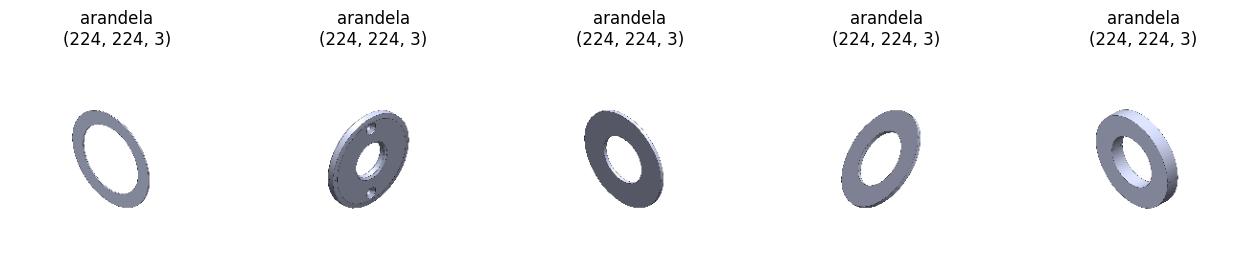

In [11]:
plot_random_image(dir_train)

## Preparación de los lotes

In [12]:
IMAGE_SIZE = (224, 224) # Permite reescalar el preprocesador de keras

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)

class_names = train_data.class_names    # Para traducir la codificación en enteros
num_classes = len(class_names)          # Para fijar en la capa de salida

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_test,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 6092 files belonging to 4 classes.
Found 1524 files belonging to 4 classes.


## CRNA - modelo y parámetros

In [13]:
# Función para configurar el guardado de los pesos a medida que se va entrenando
def create_model_check_point_callback(checkpoint_path, monitor='val_loss'):
    """
    Toma el camino donde guardar los mejores pesos modelo obtenidos durante el entrenamiento.
    """
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

In [14]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
earlystop = EarlyStopping(patience=5)

# Ajuste de tasa de aprendizaje automático
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)


ModelCheckPoint_model_cb = create_model_check_point_callback('./ModelCheckPoints/model.ckpt')

In [15]:
# Modelo de ejemplo

# Capas nuevas, especializadas para imágenes: Conv2D, MaxPooling2D, Flatten.

"""
Ver ejemplos y tipos:
    https://keras.io/api/layers/convolution_layers/
    https://keras.io/api/layers/pooling_layers/
    https://keras.io/api/layers/reshaping_layers/

En la última está Flatten, se utiliza para pasar de 2D a 1D en este caso.

Hay mucha información para la etapa de compilación, entrenamiento, etc.
"""
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))       # Importante, input_shape debe ser el tamaño de las imágenes (alto, ancho, canales)
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

## Entrenamiento

In [16]:
# Con GPU tardar unos 7 minutos
history = model.fit(train_data, epochs=50, batch_size=300, validation_data=test_data, callbacks=[earlystop, learning_rate_reduction, ModelCheckPoint_model_cb])

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 2.4006 - accuracy: 0.7370
Epoch 1: val_loss improved from inf to 0.39839, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 31s 89ms/step - loss: 2.4006 - accuracy: 0.7370 - val_loss: 0.3984 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 2/50
190/191 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8928
Epoch 2: val_loss improved from 0.39839 to 0.20245, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 16s 85ms/step - loss: 0.3083 - accuracy: 0.8930 - val_loss: 0.2025 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9206
Epoch 3: val_loss improved from 0.20245 to 0.15256, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 17s 86ms/step - loss: 0.2304 - accuracy: 0.9207 - val_loss: 0.1526 - val_accuracy: 0.95

## Evaluación de resultados

In [17]:
def plot_curves(history):
    '''
    Devuelve curvas de loss u accuracy, separadas para métricas de entrenamiento y validación.
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Pérdida en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Precisión en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

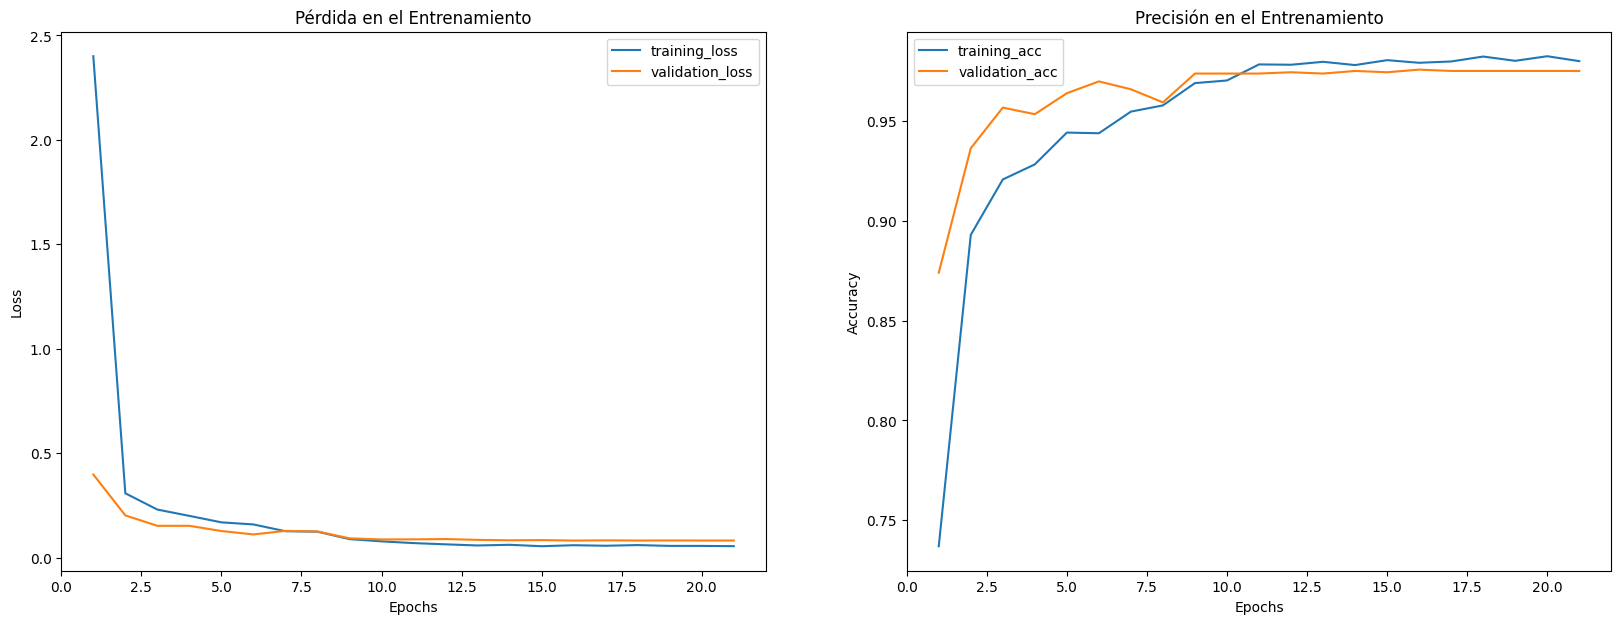

In [18]:
plot_curves(history)

In [19]:
model_result = model.evaluate(test_data)
model_result

48/48 [==============================] - 1s 25ms/step - loss: 0.0822 - accuracy: 0.9751


[0.08221518248319626, 0.9750655889511108]

In [20]:
y_pred = model.predict(test_data)

48/48 [==============================] - 1s 25ms/step


In [21]:
def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))

    return np.array(y_class)

In [22]:
# Conversión a la clase más probable
y_pred_class = predict_class(y_pred)

In [23]:
# Conversión de las clases reales
y_labels = []
for _,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

In [24]:
filepaths = []
for filepath in test_data.list_files(dir_test+'/*/*.png',shuffle=False):
    filepaths.append(filepath.numpy())

In [25]:
# Se crea un dataframe con información relacionada a las predicciones
pred_df=pd.DataFrame({
    'filepaths':filepaths,
    'y_true':y_labels,
    'y_pred':y_pred_class,
    'pred_conf':y_pred.max(axis=1),
    'actual_class_name':[class_names[i] for i in y_labels],
    'pred_class_name':[class_names[i] for i in y_pred_class]
     })
pred_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/arandela/30W_1003N_14.png',0,0,0.888074,arandela,arandela
1,b'./data/test/arandela/30W_1003N_19.png',0,0,0.838244,arandela,arandela
2,b'./data/test/arandela/30W_2505_20.png',0,0,0.999856,arandela,arandela
3,b'./data/test/arandela/30W_3005_14.png',0,0,0.999905,arandela,arandela
4,b'./data/test/arandela/30W_3505_19.png',0,0,0.999980,arandela,arandela


In [26]:
# Se filtran las imágenes que no ha podido clasificar correctamente
pred_wrong_df = pred_df[pred_df['y_true']!=pred_df['y_pred']].reset_index(drop=True)
pred_wrong_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/arandela/WC1004_5_19.png',0,1,0.545784,arandela,pasador
1,b'./data/test/arandela/WC1005_5_19.png',0,1,0.537387,arandela,pasador
2,b'./data/test/pasador/AFPQTD6-P12_5.png',1,2,0.533220,pasador,tornillo
3,b'./data/test/pasador/APUA6-P6_14.png',1,2,0.535772,pasador,tornillo
4,b'./data/test/pasador/APUA6-P6_15.png',1,2,0.782942,pasador,tornillo


In [27]:
pred_wrong_df.shape

(38, 6)

In [28]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    '''
    lee una imagen del nombre del archivo y la convierte en un tensor,
    y lo remodela al tamaño especificado.

    argumentos:
    filename: ruta a la imagen de destino.
    scale(boolean): especifica si es necesario escalar o no.

    devoluciones:
    tensor de imagen con la forma objetivo.
    '''
    img=tf.io.read_file(filename)
    img=tf.io.decode_image(img, channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])

    if scale:
        img=img/255.0
    return img

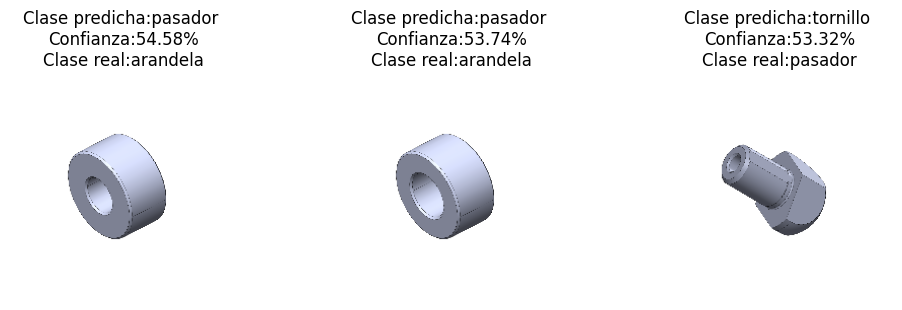

In [29]:
# Visualizar imágenes en las que se equivocó
images_to_view = 3  # Cantidad
start_index = 0     # Desde dónde comienza del df
plt.figure(figsize=(12,10))
for i,row in enumerate(pred_wrong_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_p,act_cls,prd_cls=row
    plt.imshow(img/255.0)
    plt.title(f"Clase predicha:{prd_cls} \nConfianza:{pred_p*100:.2f}%\nClase real:{act_cls}")
    plt.axis(False)

## Explicabilidad de Modelos

Visualice cómo partes de la imagen afectan la salida de la red neuronal mirando los mapas de activación.

In [30]:
!pip install tf_explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 972.2 kB/s eta 0:00:00


In [36]:
img_ver = load_and_prep_image('./test.png', scale=False)    # Imagen a visualizar, elegir path desde los df o agregar personalizado

In [31]:
img_ver = load_and_prep_image('./partes_mecanicas/tuerca/AKM_M10_1_10.png', scale=False)

In [40]:
from tf_explain.core.grad_cam import GradCAM

data=([img_ver.numpy()], None)

predict_class_index = 2     # ID de la clase [0:3]

explainer = GradCAM()
heatMap=explainer.explain(data, model, class_index=predict_class_index, layer_name="conv2d_3")      # Acá elegir el nombre de la capa convolucional desde el summary de la red.

In [38]:
def imshow(img):
    fig,ax=plt.subplots(1,1,figsize=(8,8))
    ax.imshow(img)

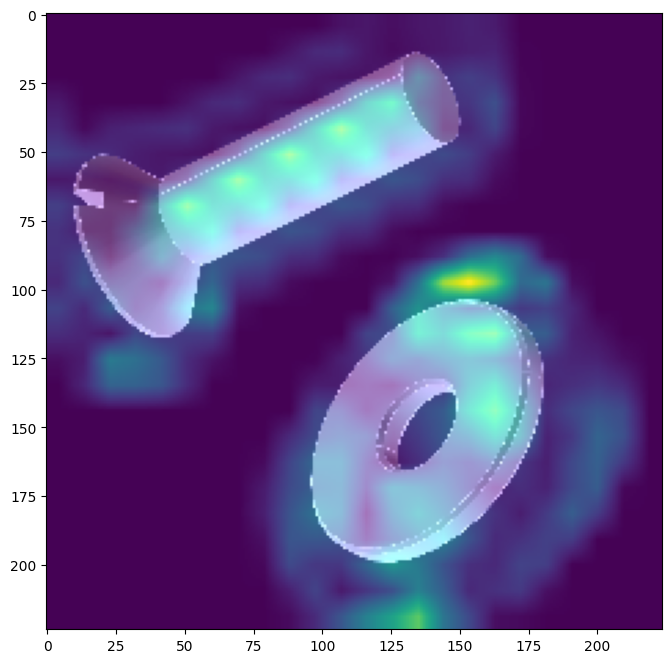

In [41]:
imshow(heatMap)

## Evaluar una imagen cualquiera con la red

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [43]:
image = load_img('./test.png', target_size=(224,224))
image = img_to_array(image)
prediction_image = np.array(image)
prediction_image = np.expand_dims(image, axis=0)

In [44]:
img_pred = model.predict(prediction_image)

1/1 [==============================] - 0s 201ms/step


In [45]:
img_pred

array([[2.4466892e-05, 3.8458366e-02, 2.3814644e-01, 7.2337073e-01]],
      dtype=float32)

In [46]:
img_pred.max(axis=1)    # Confianza con la que escogió la clase

array([0.72337073], dtype=float32)

In [47]:
class_names[predict_class(img_pred)[0]]     # Nombre de la clase

'tuerca'

In [32]:
class_names

['arandela', 'pasador', 'tornillo', 'tuerca']

# Transfer Learning

## Desde el HUB de Tensorflow

In [48]:
import tensorflow_hub as hub

# Traemos un modelo desde el HUB de TensorFlow
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))      # Esta red tiene su primer capa de este tamaño, nos viene de diez. Si se decidió reescalar las imágenes... ver alternativa.


# Modelos para un sin número de tareas en:
                                            # https://tfhub.dev/

"""
Van más ejemplos:

https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5

https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5

"""

'\nVan más ejemplos:\n\nhttps://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5\n\nhttps://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5\n\n'

In [49]:
# Los parámetros de esta red los mantenemos estáticos, ya están entrenados
mobilenetv2.trainable = False

In [ ]:
# Otra forma de construir
"""
modelo_tl = Sequential([
    mobilenetv2,
    Dense(4, activation='softmax')
])
"""

In [50]:
modelo_tl = Sequential()
modelo_tl.add(mobilenetv2)
modelo_tl.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Ejemplos, se define únicamente la etapa del clasificador para la tarea de nuestro interés
# El vector de características lo tomamos de la red ya entrenada
"""
modelo_tl = Sequential()
modelo_tl.add(mobilenetv2)
modelo_tl.add(Flatten())
modelo_tl.add(Dropout(0.5))
modelo_tl.add(Dense(num_classes*4, activation='relu'))
modelo_tl.add(Dense(num_classes, activation='softmax'))
"""

In [51]:
modelo_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [52]:
modelo_tl.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [53]:
history = modelo_tl.fit(train_data, epochs=50, batch_size=300, validation_data=test_data, callbacks=[earlystop, learning_rate_reduction, ModelCheckPoint_model_cb])

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.7956
Epoch 1: val_loss did not improve from 0.08200
191/191 [==============================] - 19s 67ms/step - loss: 0.5624 - accuracy: 0.7956 - val_loss: 0.3936 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 2/50
191/191 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8744
Epoch 2: val_loss did not improve from 0.08200
191/191 [==============================] - 12s 59ms/step - loss: 0.3458 - accuracy: 0.8744 - val_loss: 0.3263 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.2864 - accuracy: 0.9007
Epoch 3: val_loss did not improve from 0.08200
191/191 [==============================] - 11s 55ms/step - loss: 0.2862 - accuracy: 0.9007 - val_loss: 0.2867 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 4/50
190/191 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9163
Epoch 4: val_loss did not improve fro

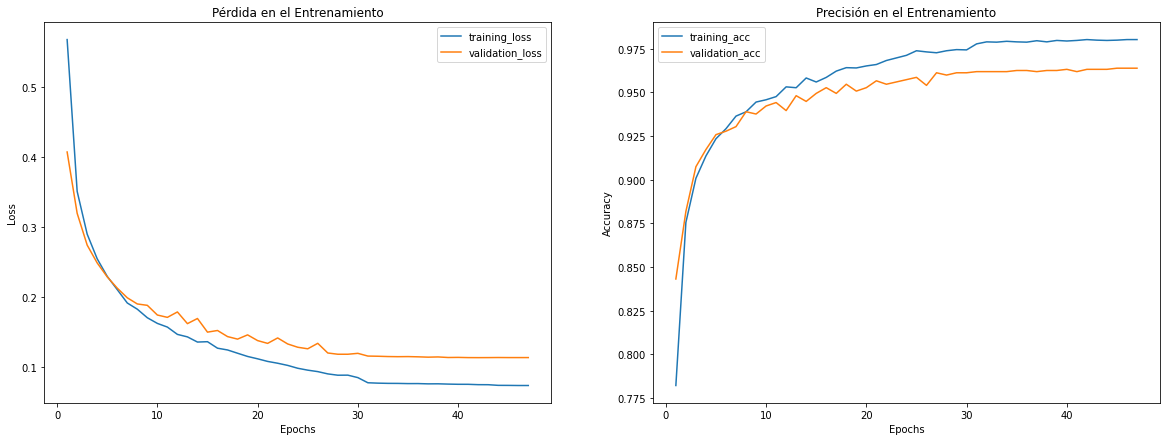

In [ ]:
plot_curves(history)

## Desde Keras

Consultar modelos en: https://keras.io/api/applications/

Se tiene información detallada respecto a los pesos, tiempos de inferencia dado el hardware de soporte, accuracy, cantidad de parámetros, profundidad de la red, etc.

Pequeño fragmento de la tabla:

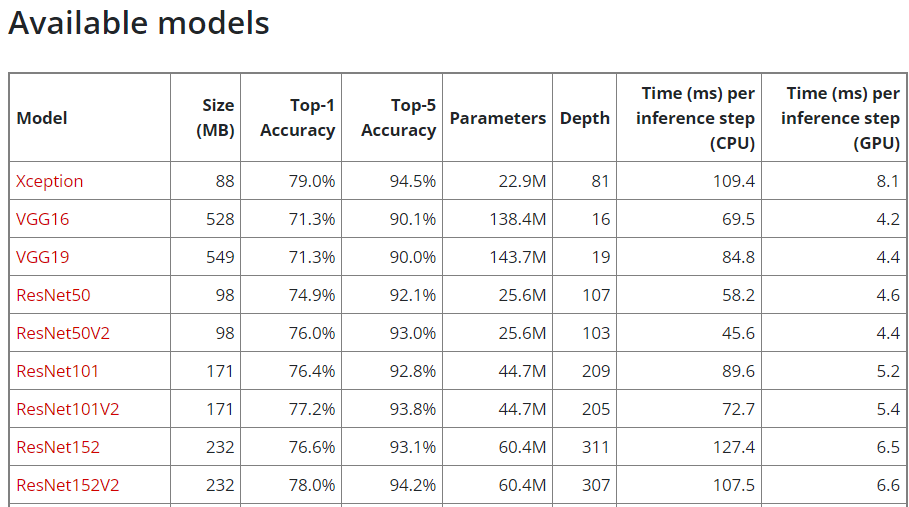

### Ejemplo con VGG16

In [54]:
from keras.models import Model
from keras.applications import VGG16

vgg_convolucional = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Se trae la red VGG16, con los pesos de imagenet (se llama así a los pesos resultantes de entrenar esta red para clasificar ese dataset)
                                                                                    # include_top=False para que recorte la salida, así agregamos nuestro clasificador
                                                                                    # input_shape para adaptar la entrada a la de nuestro interés
vgg_convolucional.trainable = False    # Apagamos los pesos de la red, 14,714,688 de parámetros para esta configuración. Ahí radica la importancia del Transfer Learning
ultima_capa = vgg_convolucional.output          # Una de las tantas formas de referenciar la última capa de la red que trajimos. A partir de acá, agregaríamos nuestras capas.

modificaciones = Flatten()(ultima_capa)
predicciones = Dense(num_classes, activation='softmax')(modificaciones)

modelo_tf_vgg = Model(vgg_convolucional.input, predicciones)
modelo_tf_vgg.summary()   # Notar que los parámetros "entrenables" son pocos en comparación a los que tiene la red completa (VGG + las capas nuestras).

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
modelo_tf_vgg.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
earlystop = EarlyStopping(patience=5)

# Ajuste de tasa de aprendizaje automático
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)


ModelCheckPoint_model_cb = create_model_check_point_callback('./ModelVGG/model.ckpt')

In [ ]:
history = modelo_tf_vgg.fit(train_data, epochs=50, batch_size=300, validation_data=test_data, callbacks=[earlystop, learning_rate_reduction, ModelCheckPoint_model_cb])

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 1.5107 - accuracy: 0.9304
Epoch 1: val_loss improved from inf to 0.38524, saving model to ./ModelVGG/model.ckpt
191/191 [==============================] - 43s 164ms/step - loss: 1.5107 - accuracy: 0.9304 - val_loss: 0.3852 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 2/50
191/191 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.9798
Epoch 2: val_loss improved from 0.38524 to 0.14077, saving model to ./ModelVGG/model.ckpt
191/191 [==============================] - 29s 150ms/step - loss: 0.3988 - accuracy: 0.9798 - val_loss: 0.1408 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 3/50
191/191 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9875
Epoch 3: val_loss did not improve from 0.14077
191/191 [==============================] - 30s 153ms/step - loss: 0.2512 - accuracy: 0.9875 - val_loss: 0.2429 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 4/50
191/191 [============================

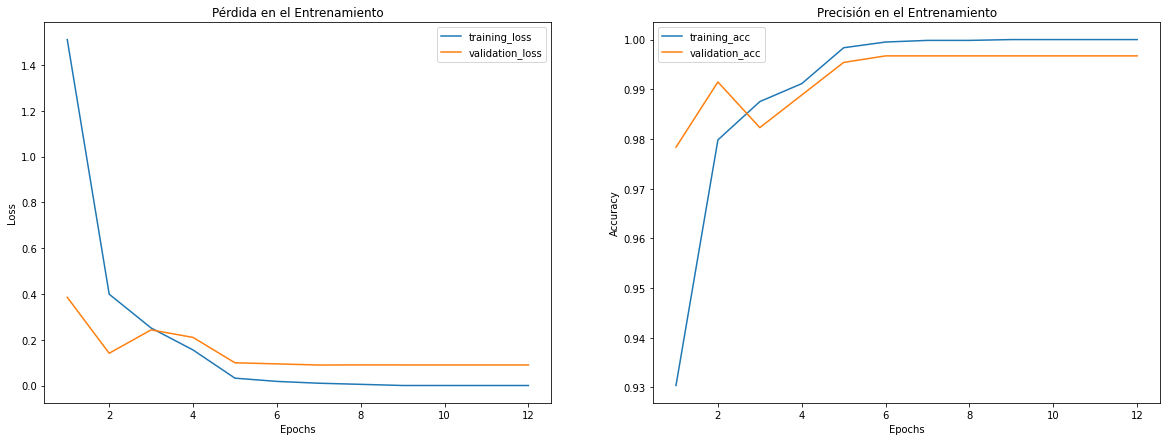

In [ ]:
plot_curves(history)

### Ejemplo con MobileNetV2

In [55]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D

# Esta es una red mucho más chica
mobileNetV2 = MobileNetV2(
                      input_shape=(224, 224, 3),
                      include_top=False,
                      weights="imagenet",
                      )

mobileNetV2.trainable = False

# Ahora con un ejemplo Secuencial. Es lo mismo que el anterior, se concatenan con .add() las capas
modelo_tf_MobileNetV2 = Sequential()
modelo_tf_MobileNetV2.add(mobileNetV2)
modelo_tf_MobileNetV2.add(GlobalAveragePooling2D())   # Ver qué hace esta capa. Arriba usé un Flatten simplemente. Ocasionó 100 k parámetros eso.
modelo_tf_MobileNetV2.add(Dense(num_classes, activation='softmax'))   # El vector de salida debe coincidir con el vector de salida de nuestros datos.

9406464/9406464 [==============================] - 1s 0us/step


In [56]:
modelo_tf_MobileNetV2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
modelo_tf_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
EPOCAS = 25
history = modelo_tf_MobileNetV2.fit(train_data, epochs=EPOCAS, batch_size=300, validation_data=test_data)

Epoch 1/25
191/191 [==============================] - 16s 63ms/step - loss: 0.5638 - accuracy: 0.7996 - val_loss: 0.3979 - val_accuracy: 0.8615
Epoch 2/25
191/191 [==============================] - 11s 58ms/step - loss: 0.3437 - accuracy: 0.8769 - val_loss: 0.3174 - val_accuracy: 0.8845
Epoch 3/25
191/191 [==============================] - 12s 61ms/step - loss: 0.2808 - accuracy: 0.9023 - val_loss: 0.2822 - val_accuracy: 0.8944
Epoch 4/25
191/191 [==============================] - 11s 58ms/step - loss: 0.2430 - accuracy: 0.9160 - val_loss: 0.2434 - val_accuracy: 0.9173
Epoch 5/25
191/191 [==============================] - 11s 58ms/step - loss: 0.2219 - accuracy: 0.9250 - val_loss: 0.2264 - val_accuracy: 0.9265
Epoch 6/25
191/191 [==============================] - 11s 58ms/step - loss: 0.2048 - accuracy: 0.9314 - val_loss: 0.2102 - val_accuracy: 0.9318
Epoch 7/25
191/191 [==============================] - 11s 58ms/step - loss: 0.1876 - accuracy: 0.9361 - val_loss: 0.1952 - val_accuracy:

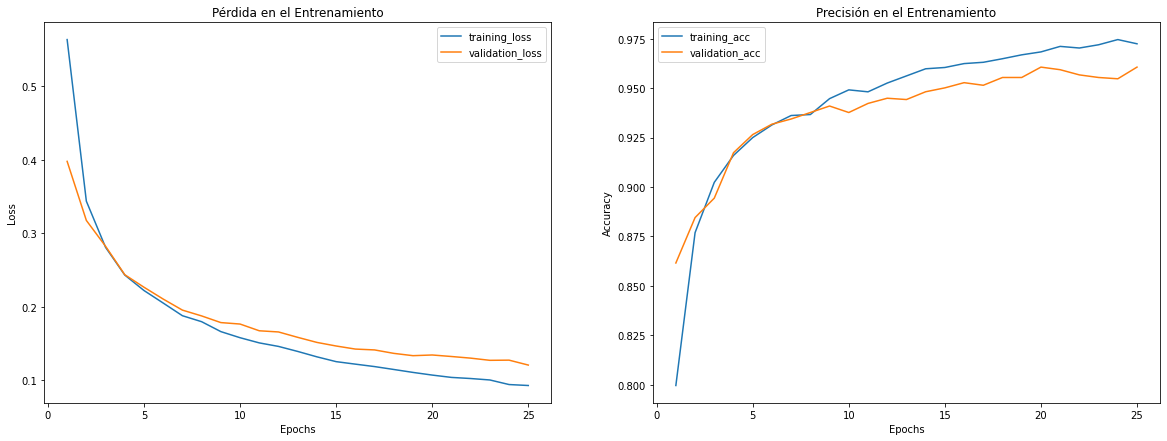

In [ ]:
plot_curves(history)

## Fine Tuning: Ajuste Fino

Una forma de aumentar aún más el rendimiento es entrenar (o "afinar") los pesos de las capas superiores del modelo preentrenado junto con el entrenamiento del clasificador que se agregó. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricas a las características asociadas específicamente con el conjunto de datos.

**Nota**: Esto solo debe intentarse después de haber entrenado el clasificador de la última capa con el modelo preentrenado establecido en no entrenable. Si agrega un clasificador inicializado aleatoriamente encima de un modelo previamente entrenado e intenta entrenar todas las capas juntas, la magnitud de las actualizaciones de gradiente será demasiado grande (debido a los pesos aleatorios del clasificador) y su modelo previamente entrenado olvidará lo que "sabía".

Además, debe intentar ajustar una pequeña cantidad de capas en lugar de todo el modelo. En la mayoría de las redes convolucionales, cuanto más profunda está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que avanza, las funciones son cada vez más específicas para el conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para que funcionen con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

### Se habilitan las capas apagadas

Todo lo que necesita hacer es descongelar el modelo base y configurar las capas superiores para que no se puedan entrenar. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.

In [ ]:
mobileNetV2.trainable = True

In [ ]:
# Capas totales del modelo
print("Número de capas del modelo importado: ", len(mobileNetV2.layers))

# Seleccionamos la capa a partir de la cuál se hará un entrenamiento afinado a nuestros datos
afinar_desde_capa = 130

# Congele todas las capas antes de la capa 'afinar_desde_capa'
for layer in mobileNetV2.layers[:afinar_desde_capa]:
  layer.trainable = False

Número de capas del modelo importado:  154


### Nueva compilación

In [ ]:
modelo_tf_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Como ahora queremos "afinar", conviene bajar la tasa de aprendizaje

In [ ]:
modelo_tf_MobileNetV2.summary()   # Ahora hay muchos más parámetros entrenables

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 1,365,124
Non-trainable params: 897,984
_________________________________________________________________


In [ ]:
# Podemos establecer número de época inicial así se puede visualizar de forma sencilla con el history del entrenamiento "grueso"
fine_tune_epochs = 10
total_epochs =  history.epoch[-1]+1 + fine_tune_epochs   # Desde la época en la que quedó el entramiento anterior. Si se piensa en "afinar", conviene no poner callbacks de finalización en el entrenamiento grueso, como para dejar parametrizado esto

history_fine = modelo_tf_MobileNetV2.fit(train_data,
                         epochs=total_epochs,
                         batch_size=300,
                         validation_data=test_data,
                         initial_epoch=history.epoch[-1]  # Continúa de la última época guardada en el history anterior
                         )

Epoch 25/35
191/191 [==============================] - 22s 70ms/step - loss: 0.4948 - accuracy: 0.9022 - val_loss: 1.2028 - val_accuracy: 0.7310
Epoch 26/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0895 - accuracy: 0.9705 - val_loss: 1.1679 - val_accuracy: 0.7146
Epoch 27/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0384 - accuracy: 0.9856 - val_loss: 1.0644 - val_accuracy: 0.7520
Epoch 28/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0279 - accuracy: 0.9921 - val_loss: 0.6354 - val_accuracy: 0.8438
Epoch 29/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0289 - accuracy: 0.9902 - val_loss: 1.3694 - val_accuracy: 0.7060
Epoch 30/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.2109 - val_accuracy: 0.9449
Epoch 31/35
191/191 [==============================] - 12s 64ms/step - loss: 0.0443 - accuracy: 0.9880 - val_loss: 0.8376 - val_ac

In [ ]:
# Se suman ambas métricas de los entrenamientos:

# Métricas del entrenamiento "grueso"
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Métricas del entrenamiento "fino"
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

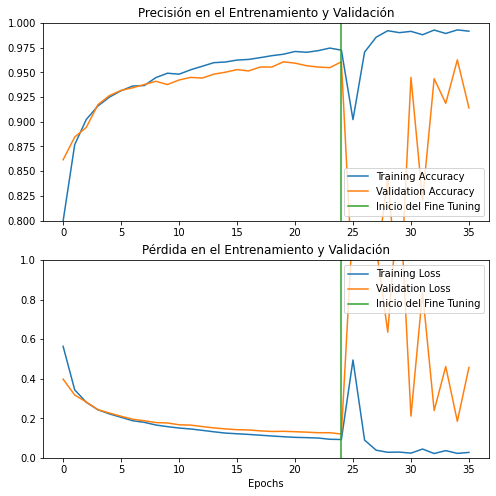

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Inicio del Fine Tuning')
plt.legend(loc='lower right')
plt.title('Precisión en el Entrenamiento y Validación')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history.epoch[-1],history.epoch[-1]],
         plt.ylim(), label='Inicio del Fine Tuning')
plt.legend(loc='upper right')
plt.title('Pérdida en el Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.show()

Notar que se percibe el aumento del error, al habilitar el entrenamiento de otras capas.

In [ ]:
# Por supuesto, puedo guardar el modelo construido con Transfer Learning
modelo_tf_MobileNetV2.save('Mi_modelo_afinado.h5')

RESUMEN:
* **Uso de un modelo previamente entrenado para la extracción de características**: cuando se trabaja con un conjunto de datos pequeño, es una práctica común aprovechar las características aprendidas por un modelo entrenado en un conjunto de datos más grande en el mismo dominio. Esto se hace instanciando el modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y solo se entrenó un clasificador que determina la clase de nuestras imágenes dado ese conjunto de características extraídas.

* **Ajuste fino de un modelo preentrenado**: para mejorar aún más el rendimiento, es posible que desee reutilizar las capas de nivel superior de los modelos preentrenados para el nuevo conjunto de datos a través del ajuste fino. En este caso, se ajustaron sus ponderaciones de modo que su modelo aprendiera características de alto nivel específicas del conjunto de datos nuevos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.

# Referencias y Recursos



*   https://pypi.org/project/tf-explain/
*   https://tf-explain.readthedocs.io/en/latest/methods.html#grad-cam
*   https://keras.io/api/layers/convolution_layers/
*   https://keras.io/api/layers/pooling_layers/
*   https://keras.io/api/layers/reshaping_layers/
*   https://tfhub.dev/

